In [ ]:
# Copyright (c) 2017 Ben Poole & Friedemann Zenke
# MIT License -- see LICENSE for details
# 
# This file is part of the code to reproduce the core results of:
# Zenke, F., Poole, B., and Ganguli, S. (2017). Continual Learning Through
# Synaptic Intelligence. In Proceedings of the 34th International Conference on
# Machine Learning, D. Precup, and Y.W. Teh, eds. (International Convention
# Centre, Sydney, Australia: PMLR), pp. 3987–3995.
# http://proceedings.mlr.press/v70/zenke17a.html

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import tensorflow as tf
slim = tf.contrib.slim
graph_replace = tf.contrib.graph_editor.graph_replace

import sys, os
sys.path.extend([os.path.expanduser('..')])
from pathint import utils
import seaborn as sns
sns.set_style("white")

from tqdm import trange, tqdm

import matplotlib.colors as colors
import matplotlib.cm as cmx

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Parameters

In [2]:
# Data params
input_dim = 784
output_dim = 10

# Network params
n_hidden_units = 2000
activation_fn = tf.nn.relu

# Optimization params
batch_size = 256
epochs_per_task = 20 
learning_rate=1e-3
xi = 0.1

# Reset optimizer after each age
reset_optimizer = False

## Construct datasets

In [3]:
n_tasks = 10
full_datasets, final_test_datasets = utils.construct_permute_mnist(num_tasks=n_tasks)
# training_datasets, validation_datasets = utils.mk_training_validation_splits(full_datasets, split_fractions=(0.9, 0.1))
training_datasets = full_datasets
validation_datasets = final_test_datasets

## Construct network, loss, and updates

In [4]:
tf.reset_default_graph()

In [5]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.InteractiveSession(config=config)
sess.run(tf.global_variables_initializer())

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(n_hidden_units, activation=activation_fn, input_dim=input_dim))
model.add(Dense(n_hidden_units, activation=activation_fn))
model.add(Dense(output_dim, activation='softmax'))

In [7]:
from pathint import protocols
from pathint.optimizers import KOOptimizer
from keras.optimizers import SGD, Adam, RMSprop
from keras.callbacks import Callback
from pathint.keras_utils import LossHistory


protocol_name, protocol = protocols.PATH_INT_PROTOCOL(omega_decay='sum', xi=xi)
# protocol_name, protocol = protocols.FISHER_PROTOCOL(omega_decay='sum')
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)
opt_name = 'adam'
# opt = SGD(lr=learning_rate)
# opt_name = 'sgd'
oopt = KOOptimizer(opt, model=model, **protocol)
model.compile(loss="categorical_crossentropy", optimizer=oopt, metrics=['accuracy'])

history = LossHistory()
callbacks = [history]

In [8]:
file_prefix = "data_%s_opt%s_lr%.2e_bs%i_ep%i_tsks%i"%(protocol_name, opt_name, learning_rate, batch_size, epochs_per_task, n_tasks)
datafile_name = "%s.pkl.gz"%(file_prefix)

## Train!

In [9]:
diag_vals = dict()
all_evals = dict()
# all_evals = utils.load_zipped_pickle(datafile_name)
# returns empty dict if file not found

def run_fits(cvals, training_data, valid_data, eval_on_train_set=False):
    for cidx, cval_ in enumerate(cvals):
        fs = []
        evals = []
        sess.run(tf.global_variables_initializer())
        cstuffs = []
        cval = cval_
        print( "setting cval")
        oopt.set_strength(cval)
        print("cval is %e"%sess.run(oopt.lam))
        for age, tidx in enumerate(range(n_tasks)):
            print("Age %i, cval is=%f"%(age,cval))
            oopt.set_nb_data(len(training_data[tidx][0]))
            stuffs = model.fit(training_data[tidx][0], training_data[tidx][1], batch_size, epochs_per_task, callbacks=callbacks,
                              verbose=0)
            oopt.update_task_metrics(training_data[tidx][0], training_data[tidx][1], batch_size)
            oopt.update_task_vars()
            ftask = []
            for j in range(n_tasks):
                if eval_on_train_set:
                    f_ = model.evaluate(training_data[j][0], training_data[j][1], batch_size, verbose=0)
                else:
                    f_ = model.evaluate(valid_data[j][0], valid_data[j][1], batch_size, verbose=0)
                ftask.append(np.mean(f_[1]))
            evals.append(ftask)
            cstuffs.append(stuffs)
            
            # Re-initialize optimizer variables
            if reset_optimizer:
                oopt.reset_optimizer()

        # diag_vals[cval_] = oopt.get_numvals('omega')
        evals = np.array(evals)
        all_evals[cval_] = evals
        
        # backup all_evals to disk
        utils.save_zipped_pickle(all_evals, datafile_name)

In [10]:
cvals = [0, 0.01, 0.1, 1.0]
print(cvals)

[0, 0.01, 0.1, 1.0]


In [11]:
# %%capture
run_fits(cvals, training_datasets, validation_datasets)

setting cval
cval is 0.000000e+00
Age 0, cval is=0.000000
Age 1, cval is=0.000000
Age 2, cval is=0.000000
Age 3, cval is=0.000000
Age 4, cval is=0.000000
Age 5, cval is=0.000000
Age 6, cval is=0.000000
Age 7, cval is=0.000000
Age 8, cval is=0.000000
Age 9, cval is=0.000000
setting cval
cval is 1.000000e-02
Age 0, cval is=0.010000
Age 1, cval is=0.010000
Age 2, cval is=0.010000
Age 3, cval is=0.010000
Age 4, cval is=0.010000
Age 5, cval is=0.010000
Age 6, cval is=0.010000
Age 7, cval is=0.010000
Age 8, cval is=0.010000
Age 9, cval is=0.010000
setting cval
cval is 1.000000e-01
Age 0, cval is=0.100000
Age 1, cval is=0.100000
Age 2, cval is=0.100000
Age 3, cval is=0.100000
Age 4, cval is=0.100000
Age 5, cval is=0.100000
Age 6, cval is=0.100000
Age 7, cval is=0.100000
Age 8, cval is=0.100000
Age 9, cval is=0.100000
setting cval
cval is 1.000000e+00
Age 0, cval is=1.000000
Age 1, cval is=1.000000
Age 2, cval is=1.000000
Age 3, cval is=1.000000
Age 4, cval is=1.000000
Age 5, cval is=1.000000


In [12]:
# backup all_evals to disk
# all_evals = dict() # uncomment to delete on disk
utils.save_zipped_pickle(all_evals, datafile_name)

In [13]:
o = oopt.get_numvals_list('omega')

In [14]:
cmap = plt.get_cmap('cool') 
cNorm  = colors.Normalize(vmin=-4, vmax=np.log(np.max(list(all_evals.keys()))))
# cNorm  = colors.Normalize()
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cmap)
print(scalarMap.get_clim())

(-4, 0.0)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':
/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


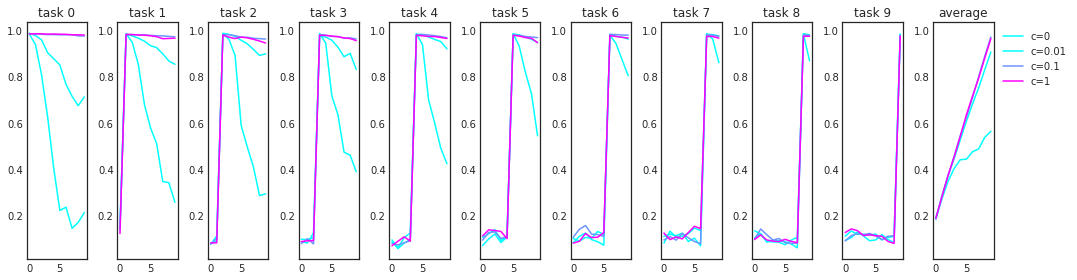

In [15]:
figure(figsize=(14, 4))
axs = [subplot(1,n_tasks+1,1)]#, None, None]
for i in range(1, n_tasks + 1):
    axs.append(subplot(1, n_tasks+1, i+1, sharex=axs[0], sharey=axs[0]))
    
keys = list(all_evals.keys())
sorted_keys = np.sort(keys)

for cval in sorted_keys:
    evals = all_evals[cval]
    for j in range(n_tasks):
        colorVal = scalarMap.to_rgba(np.log(cval))
        axs[j].plot(evals[:, j], c=colorVal)#, label="t%d, c%g"%(j, cval))
    label = "c=%g"%cval
    average = evals.mean(1)
    axs[-1].plot(average, c=colorVal, label=label)
    
for i, ax in enumerate(axs):
    ax.legend(bbox_to_anchor=(1.0,1.0))
    ax.set_title((['task %d'%j for j in range(n_tasks)] + ['average'])[i])
gcf().tight_layout()

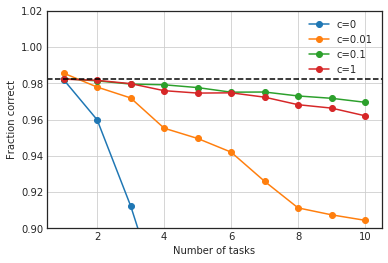

In [16]:
for cval in sorted_keys:
    stuff = []
    for i in range(len(all_evals[cval])):#n_tasks):
        stuff.append(all_evals[cval][i][:i+1].mean())
    plot(range(1,n_tasks+1), stuff, 'o-', label="c=%g"%cval)
axhline(all_evals[cval][0][0], linestyle='--', color='k')
    
xlabel('Number of tasks')
ylabel('Fraction correct')
legend(loc='best')
ylim(0.9, 1.02)
xlim(0.5, 10.5)
grid('on')

savefig("%s.pdf"%(file_prefix))